# Продвинутый метод
## Цели
- выбор модели: GradientBoosting/RandomForest/XGBoost.
- сравнение с baseline, выбор «победителя».

## Подготовка
- импортируем необходимые библиотеки
- загружаем датасет
- фиксируем параметр random_state = 42 для обеспечения воспроизводимости результатов.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import pickle

RANDOM_STATE = 42

baseline_path = '../data/interim/baseline.pkl'
with open(baseline_path, 'rb') as f:
    lr_metrics = pickle.load(f)

data_path = '../data/interim/kc_house_data_clean.csv'
df = pd.read_csv(data_path)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19264,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
19265,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
19266,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
19267,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## Предобработка данных
- удаляем ненужные столбцы id и date
- разделяем данные на обучающую и тестовую выборки в соотношении 80/20.

In [5]:
# Удаляем ненужные столбцы
df = df.drop(['id', 'date'], axis=1)
# Разделение на признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f"\nРазмеры выборок:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Размеры выборок:
X_train: (15415, 18), X_test: (3854, 18)
y_train: (15415,), y_test: (3854,)


## Функция для оценки моделей
Создаем функцию для оценки моделей, которая вычисляет основные метрики (R², MAE, RMSE) на обучающей и тестовой выборках.

In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Вычисление метрик
    metrics = {
        'R²_train': r2_score(y_train, y_train_pred),
        'R²_test': r2_score(y_test, y_test_pred),
        'MAE_train': mean_absolute_error(y_train, y_train_pred),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
    
    # Вывод результатов
    print(f"\n{'='*60}")
    print(f"Оценка модели: {model_name}")
    print(f"{'='*60}")
    print(f"R² на обучающей выборке: {metrics['R²_train']:.4f}")
    print(f"R² на тестовой выборке: {metrics['R²_test']:.4f}")
    print(f"MAE на тестовой выборке: {metrics['MAE_test']:.2f}")
    print(f"RMSE на тестовой выборке: {metrics['RMSE_test']:.2f}")
    
    return model, metrics, y_test_pred

## Обучение и оценка продвинутых моделей
### Используем модель XGBoost, так как она имеет следующие преимущества:
- улавливает сложные нелинейные зависимости в характеристиках домов
- устойчивость к выбросам
- устойчивость к переобучению
- работа с различными типами данных и распределениями
- RandomForest менее точный на многих задачах
- GradientBoosting требует более сложной настройки

In [9]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_model, xgb_metrics, xgb_pred = evaluate_model(
    xgb_model, X_train, X_test, y_train, y_test, "XGBoost"
)


Оценка модели: XGBoost
R² на обучающей выборке: 0.9643
R² на тестовой выборке: 0.8846
MAE на тестовой выборке: 57215.94
RMSE на тестовой выборке: 88056.63


## Сравнение моделей

In [10]:
# Создаем DataFrame для сравнения метрик
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'R²_test': [
        lr_metrics['R²_test'],
        xgb_metrics['R²_test']
    ],
    'MAE_test': [
        lr_metrics['MAE_test'],
        xgb_metrics['MAE_test']
    ],
    'RMSE_test': [
        lr_metrics['RMSE_test'],
        xgb_metrics['RMSE_test']
    ]
})

print("СРАВНЕНИЕ МОДЕЛЕЙ")
print(comparison_df.sort_values('R²_test', ascending=False))

# Определение лучшей модели
best_model_idx = comparison_df['R²_test'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_r2 = comparison_df.loc[best_model_idx, 'R²_test']

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"R² лучшей модели: {best_model_r2:.4f}")

СРАВНЕНИЕ МОДЕЛЕЙ
               Model   R²_test       MAE_test      RMSE_test
1            XGBoost  0.884555   57215.940991   88056.634294
0  Linear Regression  0.702899  100124.551409  141262.565658

ЛУЧШАЯ МОДЕЛЬ: XGBoost
R² лучшей модели: 0.8846
Улучшение R² по сравнению с линейной регрессией: 25.84%


## Визуализация результатов
Создаем визуализации для сравнения моделей по метрикам, а также график рассеяния для лучшей модели.

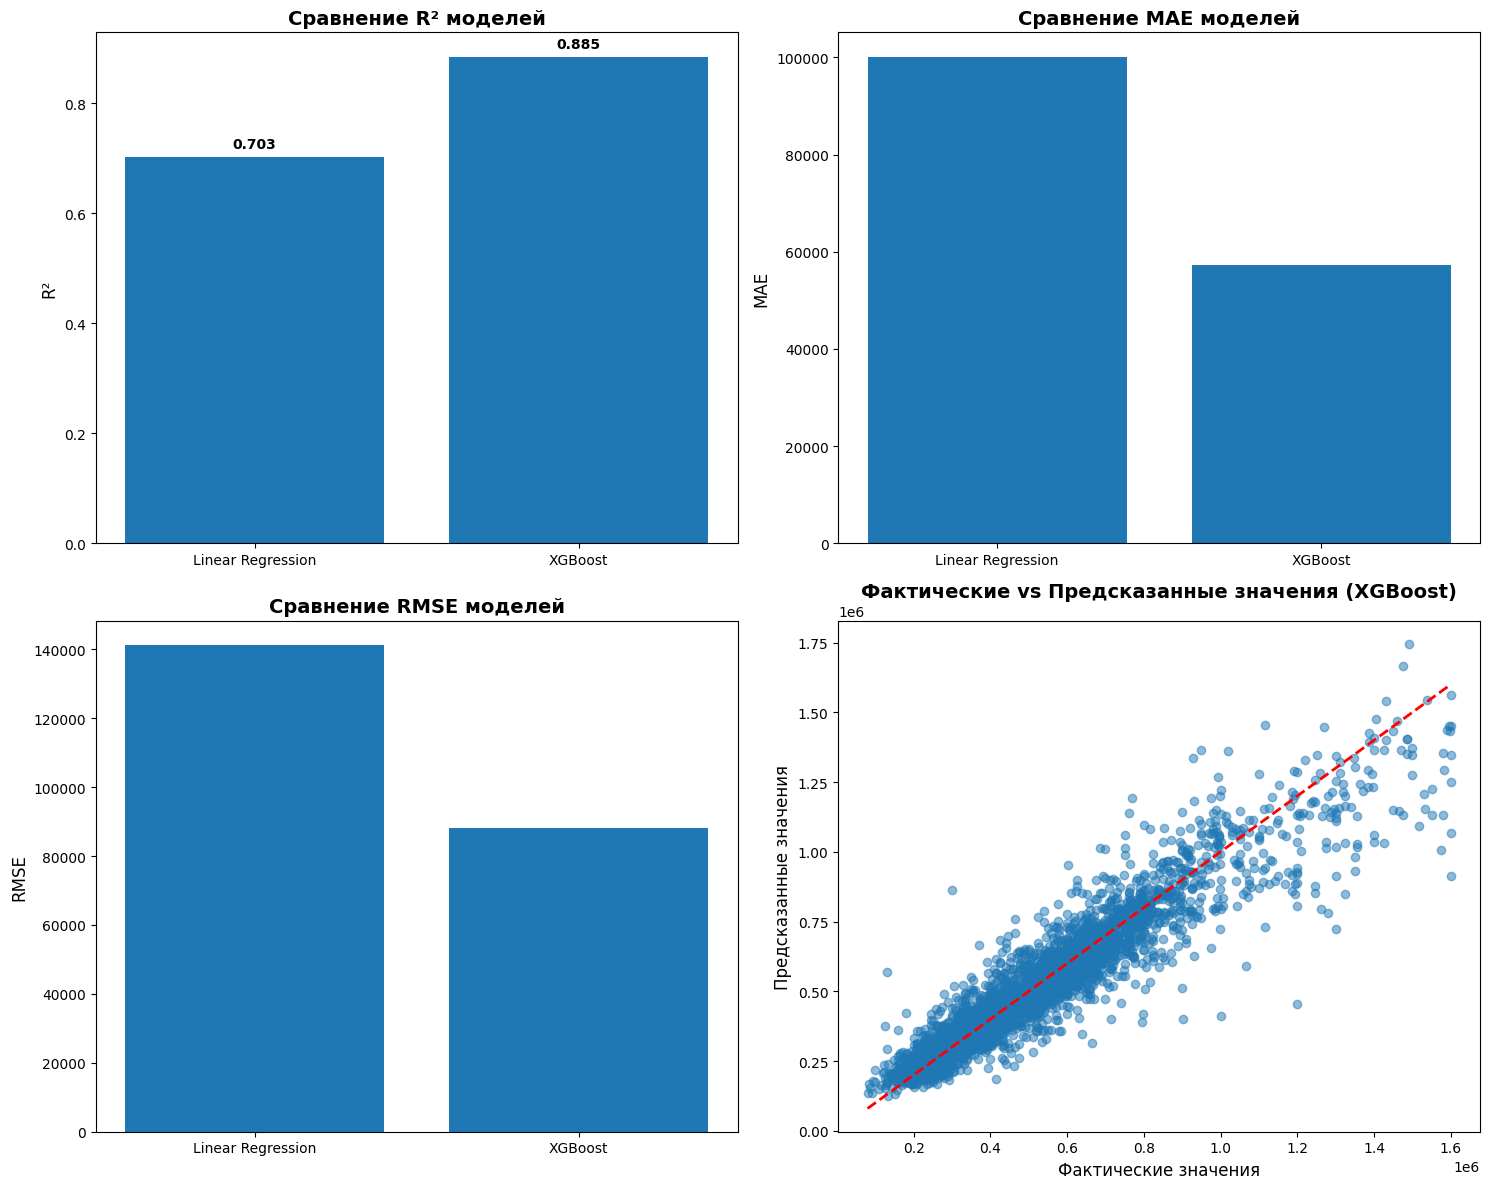

In [12]:
# 1. Сравнение метрик R²
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Сравнение R²
axes[0, 0].bar(comparison_df['Model'], comparison_df['R²_test'])
axes[0, 0].set_title('Сравнение R² моделей', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R²', fontsize=12)

# Добавляем значения на столбцы
for i, v in enumerate(comparison_df['R²_test']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# График 2: Сравнение MAE
axes[0, 1].bar(comparison_df['Model'], comparison_df['MAE_test'])
axes[0, 1].set_title('Сравнение MAE моделей', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE', fontsize=12)

# График 3: Сравнение RMSE
axes[1, 0].bar(comparison_df['Model'], comparison_df['RMSE_test'])
axes[1, 0].set_title('Сравнение RMSE моделей', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RMSE', fontsize=12)

# График 4: Фактические vs Предсказанные значения для лучшей модели
axes[1, 1].scatter(y_test, xgb_pred, alpha=0.5)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Фактические значения', fontsize=12)
axes[1, 1].set_ylabel('Предсказанные значения', fontsize=12)
axes[1, 1].set_title(f'Фактические vs Предсказанные значения ({best_model_name})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
best_metrics = comparison_df[comparison_df['Model'] == best_model_name].iloc[0]
print(f"Продвинутая модель показала значительное улучшение по сравнению с линейной регрессией:")
print(f"  Улучшение R²: {improvement:.2f}%")
print(f"  Снижение MAE: {((lr_metrics['MAE_test'] - best_metrics['MAE_test']) / lr_metrics['MAE_test'] * 100):.2f}%")
print(f"  Снижение RMSE: {((lr_metrics['RMSE_test'] - best_metrics['RMSE_test']) / lr_metrics['RMSE_test'] * 100):.2f}%")



УЛУЧШЕНИЕ ПОКАЗАТЕЛЕЙ:
  Улучшение R²: 25.84%
  Снижение MAE: 42.86%
  Снижение RMSE: 37.66%


## Итоговый вывод
XGBoost является оптимальным выбором для нашей задачи по нескольким причинам:
- лучшие результаты на тестовой выборке
- устойчивость к переобучению
- возможность анализа важности признаков
- работа с различными типами данных и распределениями
- способность улавливать сложные взаимодействия между характеристиками домов

Это делает XGBoost теоретически обоснованным и практически эффективным выбором для прогнозирования стоимости недвижимости.

In [15]:
with open('../data/interim/advanced_model.pkl', 'wb') as f:
    pickle.dump(best_metrics, f)
